# Preliminaries

In [ ]:
!pip install einops torch torchvision matplotlib seaborn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using', device)


Using cuda


In [ ]:
# 1) Define the transform 
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.4914, 0.4822, 0.4465],
                std=[0.2470, 0.2435, 0.2616])
])

# 2) Load CIFAR-10 datasets
train_ds = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
test_ds = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# 3) Create DataLoaders
train_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=64,
    shuffle=True,
    num_workers=4,         # you can tune workers for speed
    pin_memory=True        # if using GPU
)
test_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# 4) Visualization helper
def show_batch(dl, classes, n_images=16):
    """
    Plots a grid of n_images from the DataLoader dl.
    """
    images, labels = next(iter(dl))
    # Un-normalize
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
    std  = torch.tensor([0.2470, 0.2435, 0.2616]).view(3,1,1)
    imgs = images * std + mean

    grid = torchvision.utils.make_grid(imgs[:n_images], nrow=int(n_images**0.5), padding=2)
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.title(' '.join([classes[int(l)] for l in labels[:n_images]]))
    plt.show()

# 5) Usage example:
classes = train_ds.classes
show_batch(train_loader, classes, n_images=16)


100%|██████████| 170M/170M [00:14<00:00, 11.9MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


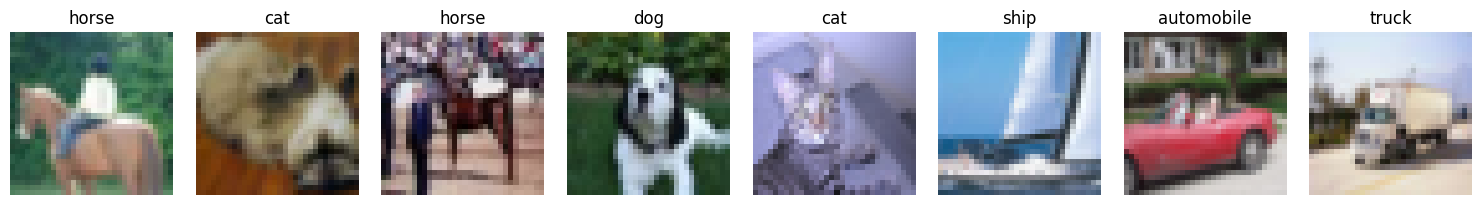

In [4]:
classes = train_ds.classes
images, labels = next(iter(train_loader))

# Prepare figure
fig, axes = plt.subplots(1, 8, figsize=(15, 2))

# Un-normalization constants
mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
std  = torch.tensor([0.2470, 0.2435, 0.2616]).view(3,1,1)

for i in range(8):
    # 1) Un-normalize the image
    img = images[i] * std + mean

    # 2) Move channels to last dimension for plt
    img = img.permute(1, 2, 0).cpu().numpy()

    # 3) Plot
    axes[i].imshow(img)
    axes[i].set_title(classes[labels[i]])
    axes[i].axis('off')

plt.tight_layout()
plt.show()


# Model

In [ ]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)


In [6]:
import torch.nn.functional as F

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


## Attention

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = heads * dim_head
        self.heads = heads
        self.scale = dim_head ** -0.5

        # 1) Layer normalization before attention
        self.norm = nn.LayerNorm(dim)

        # 2) Single linear to produce Q, K, V in one go
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        # 3) Softmax for attention weights
        self.attend = nn.Softmax(dim=-1)

        # 4) Dropout on attention weights
        self.dropout = nn.Dropout(dropout)

        # 5) Output projection back to `dim`
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x_norm = self.norm(x)
        q, k, v = self.to_qkv(x_norm).chunk(3, dim=-1)
        q = rearrange(q, 'b n (h d) -> b h n d', h=self.heads)
        k = rearrange(k, 'b n (h d) -> b h n d', h=self.heads)
        v = rearrange(v, 'b n (h d) -> b h n d', h=self.heads)

        dots = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn = self.attend(dots)
        attn = self.dropout(attn)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out, attn        # <— return both

## Transformer Block

In [ ]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        # Build `depth` layers, each with an Attention sub-block and an FFN sub-block
        self.layers = nn.ModuleList([
            nn.ModuleList([
                Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout),
                FeedForward(dim, mlp_dim, dropout=dropout)
            ]) for _ in range(depth)
        ])
        # Final layer norm after all residual blocks
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, return_attn=False):
        all_attn = []  # will hold [depth × (B, H, N, N)]
        for attn_block, ff in self.layers:
            # self-attention + residual
            x_res, attn = attn_block(x)    # now returns tuple
            x = x + x_res

            # feed-forward + residual
            x = x + ff(x)

            if return_attn:
                all_attn.append(attn)

        x = self.norm(x)
        return (x, all_attn) if return_attn else x


## ViT Model + positional embedding

In [ ]:
from einops import repeat

def get_sinusoidal_positional_embeddings(n_positions, dim, device):
    """
    Create sinusoidal positional embeddings as in “Attention Is All You Need”.
    Returns a tensor of shape (1, n_positions, dim).
    """
    position = torch.arange(n_positions, dtype=torch.float, device=device).unsqueeze(1)  # (n_positions, 1)
    div_term = torch.exp(
        torch.arange(0, dim, 2, dtype=torch.float, device=device) *
        -(torch.log(torch.tensor(10000.0)) / dim)
    )  # (dim/2,)

    pe = torch.zeros(n_positions, dim, device=device)
    pe[:, 0::2] = torch.sin(position * div_term)  # even dims
    pe[:, 1::2] = torch.cos(position * div_term)  # odd dims
    return pe.unsqueeze(0)  # (1, n_positions, dim)


class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes,
                 dim, depth, heads, mlp_dim,
                 pool='cls', channels=3,
                 dim_head=64, dropout=0., emb_dropout=0.,
                 pos_embed_type='learned'):
        """
        pos_embed_type: 'learned' (default) or 'sinusoidal'
        """
        super().__init__()
        assert pos_embed_type in {'learned', 'sinusoidal'}, "pos_embed_type must be 'learned' or 'sinusoidal'"
        self.pos_embed_type = pos_embed_type

        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)
        assert image_height % patch_height == 0 and image_width % patch_width == 0

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        # Patch embedding
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)',
                      p1=patch_height, p2=patch_width),
            nn.Linear(patch_dim, dim)
        )

        # CLS token
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        # Positional embeddings
        if pos_embed_type == 'learned':
            # trainable
            self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        else:
            # fixed sinusoidal: register as buffer so it moves with .to(device) but isn't trainable
            self.register_buffer(
                'pos_embedding',
                get_sinusoidal_positional_embeddings(num_patches + 1, dim, device='cpu'),
                persistent=False
            )

        self.dropout = nn.Dropout(emb_dropout)

        # Transformer encoder
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        # Pooling and classification head
        assert pool in {'cls', 'mean'}
        self.pool = pool
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        # 1) patchify and project
        x = self.to_patch_embedding(img)             # (B, num_patches, dim)
        b, n, _ = x.shape

        # 2) prepend cls token
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)        # (B, n+1, dim)

        # 3) add positional embeddings (learned or fixed)
        #    ensure pos_embedding is on same device & dtype as x
        pe = self.pos_embedding.to(dtype=x.dtype, device=x.device)
        x = x + pe

        # 4) dropout on embeddings
        x = self.dropout(x)

        # 5) Transformer
        x = self.transformer(x)                      # (B, n+1, dim)

        # 6) pooling
        if self.pool == 'cls':
            x = x[:, 0]
        else:
            x = x.mean(dim=1)

        # 7) classification head
        return self.mlp_head(x)


# Training Loop & Visualization

In [ ]:
def train(model, train_loader, test_loader, device,
          epochs=10, lr=3e-4):
    """
    Trains `model` on CIFAR-10 and plots training loss.

    Args:
        model       : your ViT instance
        train_loader: DataLoader for training set
        test_loader : DataLoader for test set
        device      : torch.device('cuda') or torch.device('cpu')
        epochs      : number of training epochs
        lr          : learning rate for Adam
    """
    # 1) Optimizer and loss
    opt     = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    model.to(device)
    losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.
        n_batches  = 0

        for imgs, labels in train_loader:
            # Move to device
            imgs, labels = imgs.to(device), labels.to(device)

            # Forward pass
            logits = model(imgs)               # (B, num_classes)
            loss   = loss_fn(logits, labels)

            # Backward + optimize
            opt.zero_grad()
            loss.backward()
            opt.step()

            # Accumulate
            total_loss += loss.item()
            n_batches  += 1

        # Average loss for this epoch
        avg_loss = total_loss / n_batches
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    # Plot training loss curve
    plt.figure()
    plt.plot(range(1, epochs+1), losses, marker='o')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

    # ---- Evaluation ----
    model.eval()
    correct = 0
    total   = 0

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)

    acc = 100. * correct / total
    print(f"Test Accuracy: {acc:.2f}%")


Epoch 1/20, Loss: 1.5999
Epoch 2/20, Loss: 1.2971
Epoch 3/20, Loss: 1.1841
Epoch 4/20, Loss: 1.0920
Epoch 5/20, Loss: 1.0209
Epoch 6/20, Loss: 0.9602
Epoch 7/20, Loss: 0.9045
Epoch 8/20, Loss: 0.8495
Epoch 9/20, Loss: 0.7999
Epoch 10/20, Loss: 0.7529
Epoch 11/20, Loss: 0.7072
Epoch 12/20, Loss: 0.6634
Epoch 13/20, Loss: 0.6270
Epoch 14/20, Loss: 0.5826
Epoch 15/20, Loss: 0.5448
Epoch 16/20, Loss: 0.5159
Epoch 17/20, Loss: 0.4872
Epoch 18/20, Loss: 0.4476
Epoch 19/20, Loss: 0.4240
Epoch 20/20, Loss: 0.3953


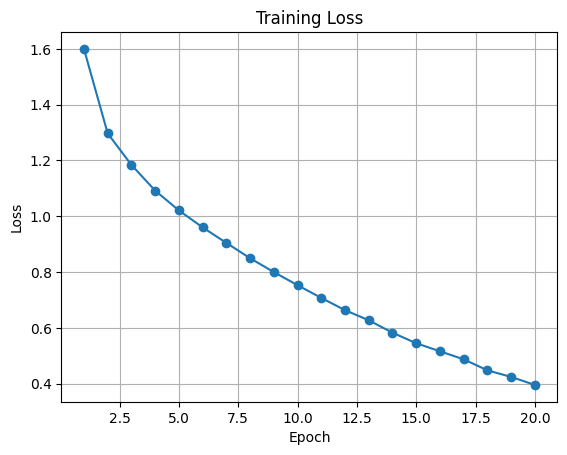

Test Accuracy: 68.07%


In [ ]:
model = ViT(
    image_size=32,
    patch_size=4,
    num_classes=10,
    dim=256,
    depth=6,
    heads=8,
    mlp_dim=512,
    pos_embed_type='learned',
    dropout=0.1,
    emb_dropout=0.1
)

train(model, train_loader, test_loader, device,
      epochs=20, lr=3e-4)


Getting less than 70% accuracy on CIFAR-10 with a basic ViT trained from scratch is pretty normal in this situation. The main reasons for this aren't due to a faulty setup, but rather the nature of the dataset and how we trained it:

1. **Dataset Size & Variety**  
   ViTs need a lot of data: Transformers, including ViT, work best when they are trained on very large image collections (like ImageNet-21k or JFT-300M) before being fine-tuned for specific tasks. Training with just 50,000 CIFAR-10 images doesn’t provide enough varied information for the model to learn effectively.

   Low resolution: CIFAR-10 images are only 32×32 pixels, which means they get broken down into just a few 4×4 patches (if we use a patch size of 4). Each patch is too simple, making it hard for the model to learn complex features.

2. **Lack of Strong Data Augmentation & Regularization**  
   No augmentation pipeline: Typical ViT or DeiT training uses strong techniques to change the images (like RandomResizedCrop, MixUp, CutMix, and RandAugment) to help prevent overfitting on small datasets. Our basic ToTensor + Normalize method makes it easier for the model to memorize the data instead of generalizing from it.

   No weight decay or learning-rate schedule: The original ViT/DeiT training uses AdamW with a decent weight decay (like 0.05) and a learning rate that changes over time. Using a constant AdamSGD schedule at a fixed rate of 3e-4 doesn’t provide the same benefits for regularization or convergence.


## Attention map

In [ ]:
def plot_attention_across_layers(attn_maps,
                                 sample_idx=0,
                                 head_idx=0,
                                 figsize=(20, 3),
                                 cmap='viridis'):
    """
    Plots attention maps for a single sample and head, across all transformer layers.

    Args:
      attn_maps   : list of length L (num layers), each tensor (B, H, N, N)
      sample_idx  : which example in the batch to visualize
      head_idx    : which head to visualize
      figsize     : overall figure size
      cmap        : matplotlib colormap
    """
    num_layers = len(attn_maps)
    fig, axes = plt.subplots(1, num_layers, figsize=figsize)
    for layer_i, attn in enumerate(attn_maps):
        # select (N, N) for this sample & head
        a = attn[sample_idx, head_idx].cpu().detach().numpy()
        ax = axes[layer_i]
        im = ax.imshow(a, cmap=cmap)
        ax.set_title(f'Layer {layer_i+1}')
        ax.axis('off')
    # add colorbar to the right of the last subplot
    fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
    plt.suptitle(f'Attention Maps — Sample {sample_idx}, Head {head_idx}', y=1.05)
    plt.tight_layout()
    plt.show()


<ipython-input-21-52efd8339259>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


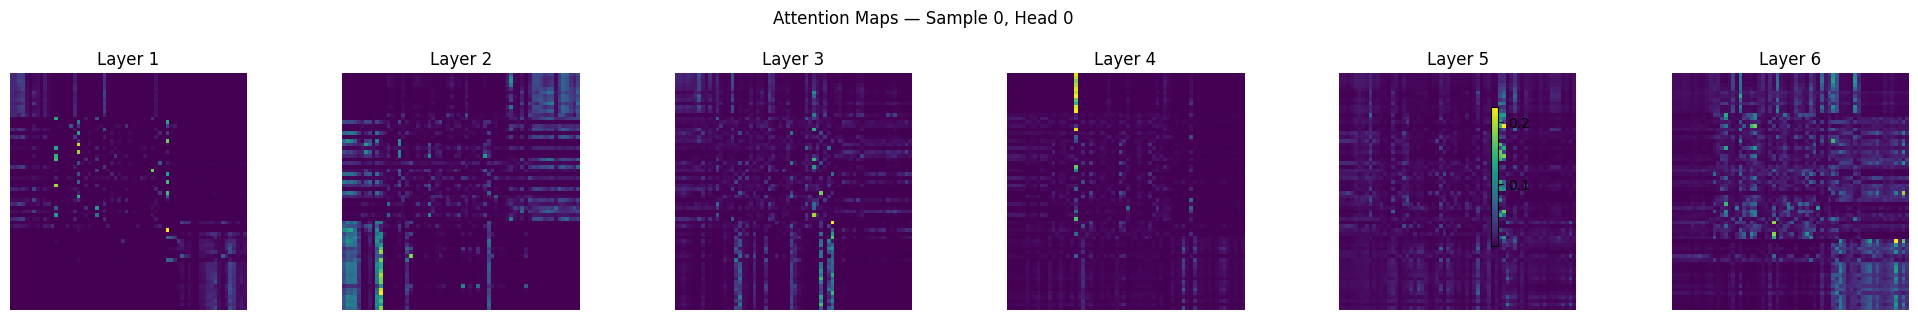

In [ ]:
# 1) Forward pass capturing attentions
model.eval()
with torch.no_grad():
    imgs, _ = next(iter(test_loader))
    imgs = imgs.to(device)
    # run through full ViT so cls + patches + position + transformer
    _ , attn_maps = model.transformer(
        model.to_patch_embedding(imgs), return_attn=True
    )

# 2) Plot head 0 across all layers for sample 0
plot_attention_across_layers(attn_maps, sample_idx=0, head_idx=0)


# Extra effort for improvement

### Sinusoidal positional embedding

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/20, Loss: 1.5256
Epoch 2/20, Loss: 1.1556
Epoch 3/20, Loss: 1.0109
Epoch 4/20, Loss: 0.9048
Epoch 5/20, Loss: 0.8120
Epoch 6/20, Loss: 0.7232
Epoch 7/20, Loss: 0.6475
Epoch 8/20, Loss: 0.5605
Epoch 9/20, Loss: 0.4782
Epoch 10/20, Loss: 0.4082
Epoch 11/20, Loss: 0.3454
Epoch 12/20, Loss: 0.2883
Epoch 13/20, Loss: 0.2462
Epoch 14/20, Loss: 0.2124
Epoch 15/20, Loss: 0.1926
Epoch 16/20, Loss: 0.1713
Epoch 17/20, Loss: 0.1579
Epoch 18/20, Loss: 0.1435
Epoch 19/20, Loss: 0.1378
Epoch 20/20, Loss: 0.1337


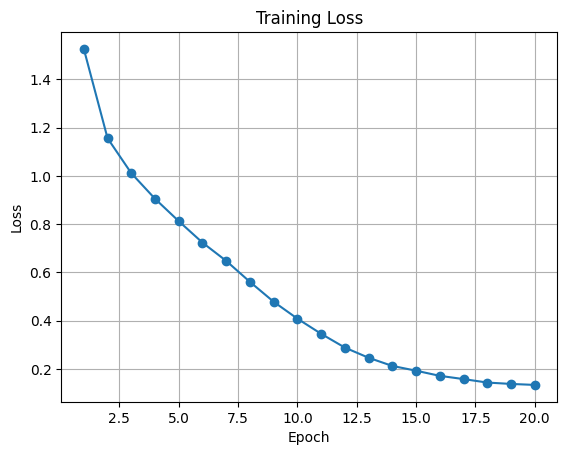

Test Accuracy: 67.49%


In [ ]:
model2 = ViT(
    image_size=32,
    patch_size=4,
    num_classes=10,
    dim=256,
    depth=6,
    heads=8,
    mlp_dim=512,
    pos_embed_type='sinusoidal'
)

train(model2, train_loader, test_loader, device,
      epochs=20, lr=3e-4)


In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

def visualize_cls_attention_with_original(
    img_tensor,
    attn_maps,
    patch_size=4,
    layer=0
):
    """
    Plots the original image and the CLS-to-patch attention overlay side by side.

    Args:
      img_tensor: torch.Tensor of shape (3, H, W), denormalized image.
      attn_maps : list of attention tensors [L × (B, heads, N, N)].
      patch_size: int, height=width of each patch.
      layer     : int, which transformer layer to visualize.
    """
    # Extract attention
    attn = attn_maps[layer][0]   # (heads, N, N)
    heads, N, _ = attn.shape
    _, H, W = img_tensor.shape
    grid_h, grid_w = H // patch_size, W // patch_size
    expected = grid_h * grid_w

    # CLS→patch attention
    if N == expected + 1:
        cls_attn = attn[:, 0, 1:]
    elif N == expected:
        cls_attn = attn[:, 0, :]
    else:
        raise ValueError(f"Unexpected token count N={N}")

    mean_attn = cls_attn.mean(dim=0)  # (patches,)

    # Make attention map
    attn_grid = mean_attn.reshape(grid_h, grid_w).unsqueeze(0).unsqueeze(0)
    attn_map  = F.interpolate(
        attn_grid, size=(H, W), mode='bilinear', align_corners=False
    ).squeeze().cpu().numpy()

    # Prepare image
    img = img_tensor.cpu().permute(1,2,0).numpy()
    img_norm = (img - img.min()) / (img.max() - img.min())

    # Plot side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    # Original
    ax1.imshow(img_norm)
    ax1.set_title('Original Image')
    ax1.axis('off')
    # Overlay
    ax2.imshow(img_norm)
    ax2.imshow(attn_map, cmap='inferno', alpha=0.6)
    ax2.set_title(f'Layer {layer+1} Attention')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()


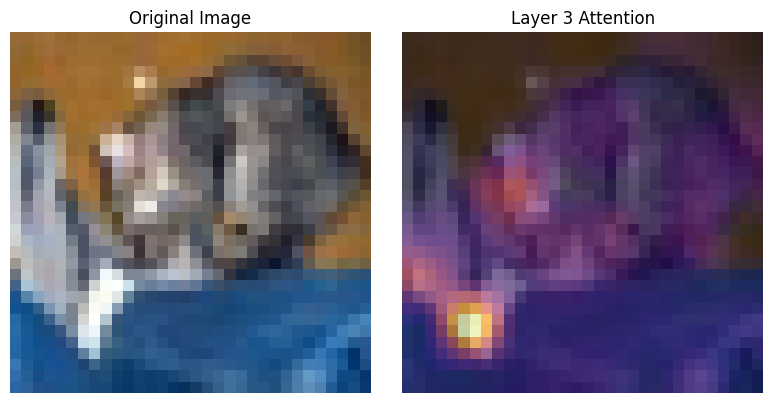

In [ ]:
model.eval()
with torch.no_grad():
    imgs, _ = next(iter(test_loader))
    imgs = imgs.to(device)
    _ , attn_maps = model2.transformer(
        model.to_patch_embedding(imgs), return_attn=True
    )

# 2) Select the first image
img0 = imgs[0]

# 3) Visualize original + attention overlay for layer 3
visualize_cls_attention_with_original(
    img_tensor=img0,
    attn_maps=attn_maps,
    patch_size=4,
    layer=2    # zero-indexed → layer 3
)

### Differnet batch sizes


=== Batch size: 32 ===
  Epoch 1/10 — Loss: 1.5790
  Epoch 2/10 — Loss: 1.3091
  Epoch 3/10 — Loss: 1.1996
  Epoch 4/10 — Loss: 1.1298
  Epoch 5/10 — Loss: 1.0720
  Epoch 6/10 — Loss: 1.0191
  Epoch 7/10 — Loss: 0.9674
  Epoch 8/10 — Loss: 0.9241
  Epoch 9/10 — Loss: 0.8821
  Epoch 10/10 — Loss: 0.8436
  → Test Accuracy: 64.50%

=== Batch size: 64 ===
  Epoch 1/10 — Loss: 1.5777
  Epoch 2/10 — Loss: 1.2860
  Epoch 3/10 — Loss: 1.1720
  Epoch 4/10 — Loss: 1.0872
  Epoch 5/10 — Loss: 1.0147
  Epoch 6/10 — Loss: 0.9562
  Epoch 7/10 — Loss: 0.8999
  Epoch 8/10 — Loss: 0.8495
  Epoch 9/10 — Loss: 0.8021
  Epoch 10/10 — Loss: 0.7530
  → Test Accuracy: 65.49%

=== Batch size: 128 ===
  Epoch 1/10 — Loss: 1.6431
  Epoch 2/10 — Loss: 1.3101
  Epoch 3/10 — Loss: 1.1770
  Epoch 4/10 — Loss: 1.0852
  Epoch 5/10 — Loss: 1.0071
  Epoch 6/10 — Loss: 0.9384
  Epoch 7/10 — Loss: 0.8773
  Epoch 8/10 — Loss: 0.8247
  Epoch 9/10 — Loss: 0.7757
  Epoch 10/10 — Loss: 0.7241
  → Test Accuracy: 64.97%

=== B

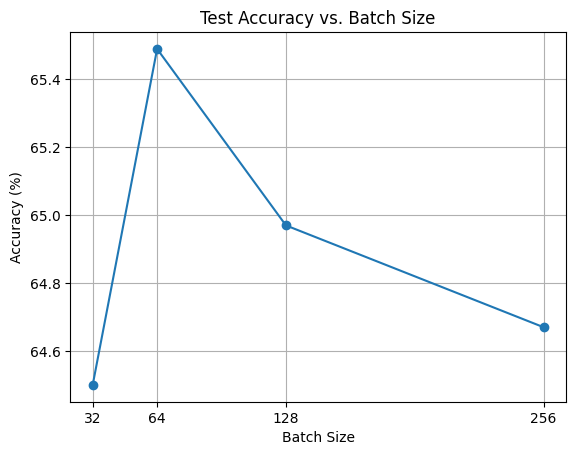

Batch Size | Final Test Accuracy
        32 |  64.50%
        64 |  65.49%
       128 |  64.97%
       256 |  64.67%


In [24]:
from collections import defaultdict

def run_batch_size_sweep(batch_sizes, model_cfg, device, epochs=10, lr=3e-4):
    """
    Sweeps over batch_sizes, trains a fresh ViT for each, and returns a dict:
      results[bs] = {
        'losses': [...],       # length = epochs
        'test_accuracy': float
      }
    """
    results = {}
    for bs in batch_sizes:
        print(f"\n=== Batch size: {bs} ===")
        # 1) Create loaders
        train_loader = torch.utils.data.DataLoader(
            train_ds, batch_size=bs, shuffle=True,
            num_workers=4, pin_memory=True
        )
        test_loader = torch.utils.data.DataLoader(
            test_ds, batch_size=bs, shuffle=False,
            num_workers=4, pin_memory=True
        )

        # 2) Instantiate a fresh model
        model = ViT(**model_cfg).to(device)

        # 3) Optimizer & loss
        opt     = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()

        epoch_losses = []
        for epoch in range(epochs):
            model.train()
            total_loss = 0.0
            for imgs, labels in train_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                logits = model(imgs)
                loss = loss_fn(logits, labels)

                opt.zero_grad()
                loss.backward()
                opt.step()

                total_loss += loss.item()
            avg_loss = total_loss / len(train_loader)
            epoch_losses.append(avg_loss)
            print(f"  Epoch {epoch+1}/{epochs} — Loss: {avg_loss:.4f}")

        # 4) Evaluate
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = model(imgs).argmax(dim=1)
                correct += (preds == labels).sum().item()
                total   += labels.size(0)
        acc = 100. * correct / total
        print(f"  → Test Accuracy: {acc:.2f}%")

        # 5) Store results
        results[bs] = {
            'losses': epoch_losses,
            'test_accuracy': acc
        }

    return results

# ----------------------
# Usage:

model_cfg = dict(
    image_size=32,
    patch_size=4,
    num_classes=10,
    dim=256,
    depth=6,
    heads=8,
    mlp_dim=512,
    pos_embed_type='learned',
    dropout=0.1,
    emb_dropout=0.1
)

batch_sizes = [32, 64, 128, 256]
results = run_batch_size_sweep(batch_sizes, model_cfg, device,
                               epochs=10, lr=3e-4)

# ----------------------
# Plot test accuracy vs. batch size
plt.figure()
plt.plot(batch_sizes, [results[bs]['test_accuracy'] for bs in batch_sizes], marker='o')
plt.title("Test Accuracy vs. Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Accuracy (%)")
plt.xticks(batch_sizes)
plt.grid(True)
plt.show()

# ----------------------
# (Optional) Print a summary table:
print("Batch Size | Final Test Accuracy")
for bs in batch_sizes:
    print(f"{bs:10d} | {results[bs]['test_accuracy']:6.2f}%")


**There is a clear “sweet-spot” around batch size 64.**
The model trained with B=64 achieved the highest test accuracy (65.49 %), outperforming both smaller (32) and larger (128, 256) batches.  

**Too-small batches introduce excessive gradient noise.**  
With B=32, the loss landscape is sampled more noisily each step. This stochasticity can act as regularization, but here it under-utilized the gradient signal—yielding slightly lower accuracy (64.50 %).  

**Too-large batches can hurt generalization.**
As batch size grows (128, 256), the gradient estimate becomes more stable but less noisy, which often accelerates convergence yet tends to overfit the training set. We see this as a drop in accuracy compared to B=64.  

**Overall sensitivity is modest (~1 % swing).**  
The variation between best (65.49 %) and worst (64.50 %) is under one percentage point. This suggests the ViT’s performance on CIFAR-10 is relatively robust to batch-size choice in this range, though a moderate batch size is optimal.
